# Introduction

Not comfortable publishing this... the enrichment is not robust.

# Setup

In [734]:
import pandas as pd
import pybedtools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc
import scipy.stats as stats
import numpy as np
from tqdm.notebook import tqdm

import re
from functools import reduce
import itertools as it
import pickle as pkl


from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [2]:
mountpoint = '/data/clue/'
prefix_pks = mountpoint + 'amo/atac/peaks/'
prefix_eqtl = mountpoint + 'prod/eqtl/'

In [423]:
cts_enrich = ['T4_Naive', 'B_cells', 'myeloid_cells']

## Definitions

In [424]:
def filter_vals(df, group_name, id_name, filter_name, top_num=None, thresh=None, groups=None):
    '''
    filter_name is used to further filter the group-specific values
    top_num keeps the highest _n_ values in df[group_name]
    thresh, a single value or dict of values with df[group_name].unique() as keys, keeps the values with df[group_name] > _n_
    '''
    thresh_None = isinstance(thresh, type(None))
    top_num_None = isinstance(top_num, type(None))
    filtered = list()
    if sum([top_num_None, thresh_None]) != 1:
        raise(ValueError, "Must provide either thresh or top_num.")
    
    if isinstance(groups, type(None)):
        unique_groups = df[group_name].unique()
    else:
        unique_groups = groups
    
    if thresh_None and type(top_num) != dict:
        top_num = dict(it.product(unique_groups, [top_num]))
    elif top_num_None and type(thresh) != dict:
        thresh = dict(it.product(unique_groups, [thresh]))
    for g in unique_groups:
        sub_df = df[df[group_name] == g]
        if thresh_None:
            sub_df = sub_df.sort_values(by=filter_name, ascending=False)[:top_num[g]]
        else:
            sub_df = sub_df[sub_df[filter_name] > thresh[g]]
        filtered.append(sub_df)
    return pd.concat(filtered, axis=0)

In [425]:
def find_specific_vals(labels, list_of_arrays, pbar=False):
    '''
    labels is a list of labels for each group
    list_of_arrays is a list of arrays, where each array is from a group in the same order as labels
    '''
    labels = list(cts_enrich)
    array_dict = dict(zip(labels, list_of_arrays))
    specific = dict()
    if pbar:
        for label, other_labels in tqdm([(label, set(labels).difference({label})) for label in labels]):
            union_of_other = reduce(np.union1d, [array_dict[o_label] for o_label in other_labels])
            specific[label] = np.setdiff1d(array_dict[label], union_of_other)
    else:
        for label, other_labels in [(label, set(labels).difference({label})) for label in labels]:
            union_of_other = reduce(np.union1d, [array_dict[o_label] for o_label in other_labels])
            specific[label] = np.setdiff1d(array_dict[label], union_of_other)
    return specific

In [426]:
def get_specific_df(df, group_name, id_name, specific_vals, filter_vals_params=None, groups=None):
    '''
    Filter your df to group_name-specific, high-quality values.
    df is a pd.DataFrame with group_name, id_name, and filter name as columns
    df is first split by unique values in group name
    id_name and specific_vals is used to find the values specific to that group
    specific_vals is a dict with df[group_name].unique() as keys and a subset of df[id_name].unique() as values
    '''
    specific = list()
    if isinstance(groups, type(None)):
        unique_groups = df[group_name].unique()
    else:
        unique_groups = groups
    for g in unique_groups:
        sub_df = df[df[group_name] == g]
        sub_df = sub_df[sub_df[id_name].isin(specific_vals[g])]
        specific.append(sub_df)
    return pd.concat(specific, axis=0)

In [737]:
with open(mountpoint + 'ct5_colors.pkl', 'rb') as file:
    ct_colors = pkl.load(file)

# Broad Enrichment using Published Peak Set

## Lupus Paper Peaks

Load in the peaks used in [Calderon et al](https://web.stanford.edu/group/pritchardlab/dataArchive/immune_atlas_web/index.html). Because we don't have exact matches to their cell types, I will use `T4_Naive` as a proxy for `T`.

In [441]:
mapper = {
    'T': 'T4_Naive',
    'B': 'B_cells',
    'myeloid_resting': 'myeloid_cells'
}

rev_mapper = dict([(v, k) for k, v in mapper.items()])

In [440]:
atac_specific = pd.read_csv('/data/codec2/external/simple_sorted_atac_lineage_groups.txt.gz', sep='\t') # Pretty sure these are hg19
atac_specific = atac_specific[atac_specific['group'].isin(['T', 'B', 'myeloid_resting'])]
atac_specific['group'] = atac_specific['group'].replace(mapper)
atac_specific.columns = ['chrom', 'start', 'end', 'group']
genome = 'hg19'

## Find Specific eQTLs

### `MatrixeQTL` results

In [428]:
mateqtl_df = pd.read_pickle(prefix_eqtl + 'mateqtl/pkls/mateqtl_df.pkl')
mateqtl_df_C = mateqtl_df[mateqtl_df['cond'] == 'C'].copy()

In [429]:
fdr_thresh = 1
mateqtl_df_C_sig = mateqtl_df_C[mateqtl_df_C['FDR'] < fdr_thresh].copy()

In [430]:
snp_map = dict([(v, k) for (k, v) in dict(enumerate(mateqtl_df_C_sig['hg19_snps'].unique())).items()])
mateqtl_df_C_sig['snp_id'] = mateqtl_df_C_sig['hg19_snps'].map(snp_map)

In [431]:
mateqtl_df_C_sig['cell_type'].value_counts()

myeloid_cells    291929
T4_Naive         289926
T4_Mem           274396
T8_Naive         274120
B_cells          264434
NK_T_Tox         262149
Name: cell_type, dtype: int64

In [432]:
specific_vals = find_specific_vals(cts_enrich, [mateqtl_df_C_sig[mateqtl_df_C_sig['cell_type'] == g]['snp_id'].values for g in cts_enrich])

In [433]:
eqtl_specific = get_specific_df(mateqtl_df_C_sig, 'cell_type', 'snp_id', specific_vals, groups=cts_enrich)

In [434]:
eqtl_specific['cell_type'].value_counts()

myeloid_cells    164736
T4_Naive         159853
B_cells          146241
Name: cell_type, dtype: int64

In [435]:
enrichment_result = list()
merged_lens = list()


for ct in cts_enrich:

    # Result is straight from Matrix eQTL
    result = eqtl_specific[(eqtl_specific['cell_type'] == ct)].copy()
    result['chr'] = 'chr' + result[genome + '_snps'].str.split(':').str[0]
    result['pos'] = result[genome + '_snps'].str.split(':').str[1]

    for group in tqdm(atac_specific.group.drop_duplicates()):

        atac_group = atac_specific.query('group == "{}"'.format(group))[['chrom', 'start', 'end', 'group']]

        snp_locs = result[['chr', 'pos']].copy()
        snp_locs['end'] = snp_locs['pos'].astype(int)+1

        a = pybedtools.BedTool.from_dataframe(snp_locs)
        b = pybedtools.BedTool.from_dataframe(atac_group)

        c = b.intersect(a)
        try:
            c = c.to_dataframe()
        except pd.errors.EmptyDataError:
            enrichment_result.append((ct, group, 1))
            continue
        c.columns=['chr', 'pos', 'end', 'group']

        c['pos'] = c['pos'].astype(str)

        merged = result.merge(c, on=['chr', 'pos'], how='left')

        merged['in_peak'] = merged['group'] == group
        

        pv = stats.mannwhitneyu(-np.log(merged.query('in_peak')['pvalue']), -np.log(merged.query('~in_peak')['pvalue']))[1]
        
        merged_lens.append((ct, group, merged.shape[0]))
        enrichment_result.append((ct, group, pv))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [436]:
enrichment_df = -np.log10(pd.DataFrame(enrichment_result, columns=['ct', 'group', 'pv']).pivot(index=['ct'], columns=['group']))
merged_lens_df = pd.DataFrame(merged_lens, columns=['ct', 'group', 'pv']).pivot(index=['ct'], columns=['group']).fillna(0)

In [437]:
enrichment_df.columns = enrichment_df.columns.droplevel(0)
merged_lens_df.columns = merged_lens_df.columns.droplevel(0)

In [438]:
enrichment_df = enrichment_df.rename(columns=rev_mapper)
merged_lens_df = merged_lens_df.rename(columns=rev_mapper)

In [442]:
merged_lens_df

group,B,T,myeloid_resting
ct,,,
B_cells,146345,146379,146307
T4_Naive,160013,160055,159929
myeloid_cells,164880,164918,164894


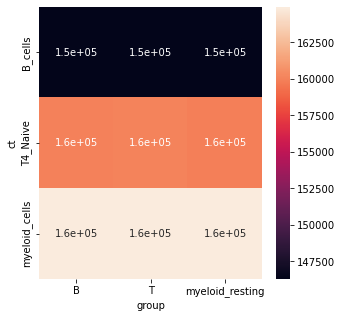

In [445]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(merged_lens_df, annot=True, ax=ax);

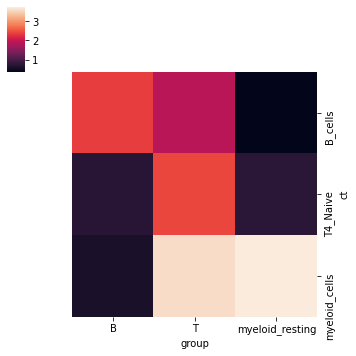

In [450]:
sns.clustermap(enrichment_df, 
#                standard_scale=1,
               row_cluster=False, col_cluster=False, figsize=(5, 5));

# Find eQTL-controlled Genes Specific to Each Cell Type

## Filter `mateqtl_df`

In [472]:
cts = ['T8_Naive', 'T4_Naive', 'T4_Mem', 'NK_T_Tox', 'B_cells', 'myeloid_cells']

In [627]:
gene_group_dict = dict()

Define a new `pd.DataFrame` that only contains eQTLs with high absolute beta in the control conditions.

0.030786512928954887


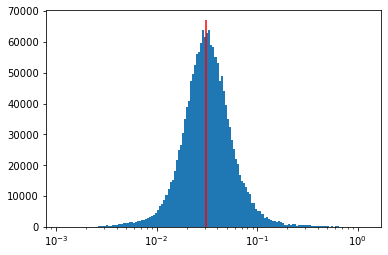

In [469]:
n, bins, patches = plt.hist(mateqtl_df_C['abs(beta)'].values, bins=np.logspace(np.log10(mateqtl_df_C['abs(beta)'].min()), np.log10(1.2), 150));
max_bin = bins[np.argsort(n)[-3:]].mean()
plt.vlines(max_bin, *plt.ylim(), color='red');
plt.xscale('log')
print(max_bin)

In [740]:
fdr_thresh = 1
beta_thresh = 0.0308
revised_kmeans_order = [5, 7, 1, 2, 0, 4, 8, 6, 9, 10, 3]
cpg_sum_thresh = 5
n_clusts = 11
meanlogcpg_thresh = 2
gene_group_dict = dict(zip(cts, revised_kmeans_order))
peak_score_thresh = 5
top_num_peaks = 25000

In [ ]:
fdr_thresh = 0.5
beta_thresh = 0.05
revised_kmeans_order = [2, 5, 7, 6, 0, 4, 8, 3, 1, 9]
cpg_sum_thresh = 5
n_clusts = 10
meanlogcpg_thresh = 1
gene_group_dict = dict(zip(cts, revised_kmeans_order))
peak_score_thresh = 6
top_num_peaks = 25000

In [741]:
mateqtl_df_filt = pd.concat([mateqtl_df_C[((mateqtl_df_C['cell_type'] == ct) & 
                                           (mateqtl_df_C['FDR'] < fdr_thresh) & 
                                           (mateqtl_df_C['abs(beta)'] > beta_thresh)
                                          )] for ct in cts]).sort_values(by='abs(beta)', ascending=False)

In [742]:
mateqtl_df_filt['cell_type'].value_counts()

myeloid_cells    208260
B_cells          186552
T8_Naive         149752
T4_Mem           127544
NK_T_Tox         124634
T4_Naive          66342
Name: cell_type, dtype: int64

In [743]:
mdf_top = pd.concat([mateqtl_df_filt[mateqtl_df_filt['cell_type'] == ct].iloc[:15000] for ct in cts])

In [744]:
counts_per_gene = mdf_top.groupby(['gene', 'cell_type']).count().iloc[:,0].rename('count').to_frame().unstack('cell_type').fillna(0).T.astype(int)
counts_per_gene.index = counts_per_gene.index.droplevel()

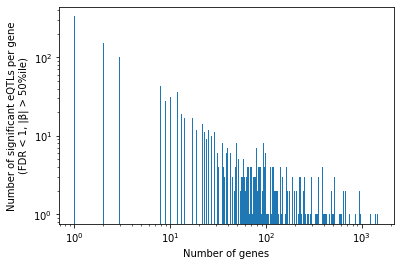

In [745]:
plt.hist(counts_per_gene.sum().values, bins=np.logspace(np.log10(1), np.log10(1500), 500));
plt.xscale('log');
plt.yscale('log');
plt.xlabel('Number of genes')
plt.ylabel('Number of significant eQTLs per gene\n(FDR < %s, |β| > %s)' % (str(fdr_thresh), '50%ile'));

In [746]:
counts_per_gene = counts_per_gene.loc[:, counts_per_gene.sum() >= cpg_sum_thresh].copy() # hiscore

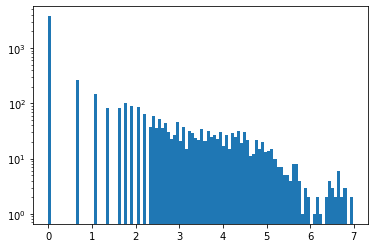

In [747]:
log_cpg = np.log1p(counts_per_gene.loc[cts])
plt.hist(log_cpg.values.flatten(), bins=100);
plt.yscale('log');

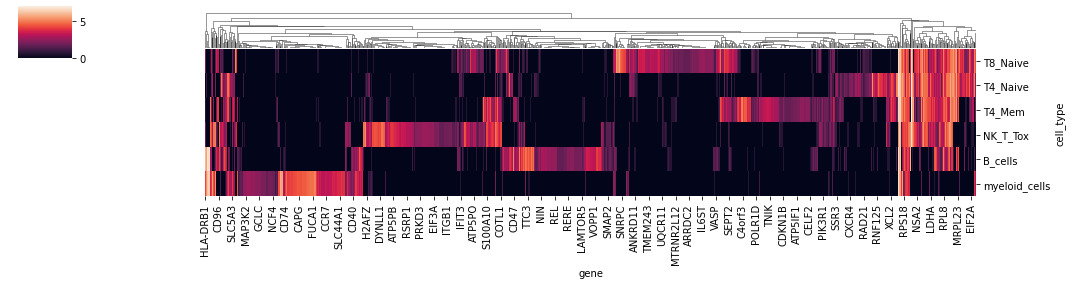

In [748]:
sns.clustermap(log_cpg, row_cluster=False, figsize=(15,4));

## Clustering by KMeans

Code for finding optimal k taken from [here](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

In [749]:
distortions = list()
# K = np.concatenate(([1],np.arange(5,55,5)))
K = np.concatenate(([1],np.arange(2,40,2)))
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k).fit(log_cpg.T)
    kmeanModel.fit(log_cpg.T)
    distortions.append(sum(np.min(cdist(log_cpg.T, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / log_cpg.T.shape[0])

  0%|          | 0/20 [00:00<?, ?it/s]

In [750]:
rise = [distortions[i] - distortions[i - 1] for i in range(1, len(K))]
run = [K[i] - K[i - 1] for i in range(1, len(K))]
slopes = np.array([-i/j for i, j in zip(rise, run)])

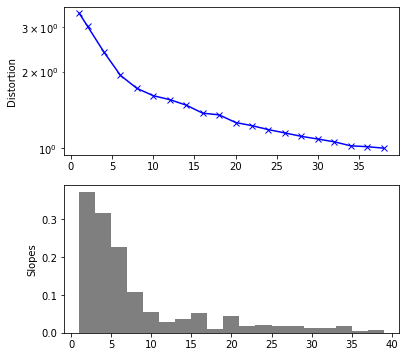

In [751]:
# Plot the elbow
fig, ax = plt.subplots(2, 1, figsize=(6,6))
ax[0].plot(K, distortions - min(distortions) + 1, 'bx-')
ax[0].set_ylabel('Distortion')
ax[0].set_yscale('log')
ax[1].bar(K[1:], slopes, width=2, color='k', alpha=0.5)
ax[1].set_ylabel('Slopes');

In [752]:
kmeans = KMeans(n_clusters=n_clusts,
                random_state=0
               ).fit(log_cpg.T)

In [753]:
kmeans_color_dict = dict(zip(range(n_clusts),sc.pl.palettes.default_20*2))

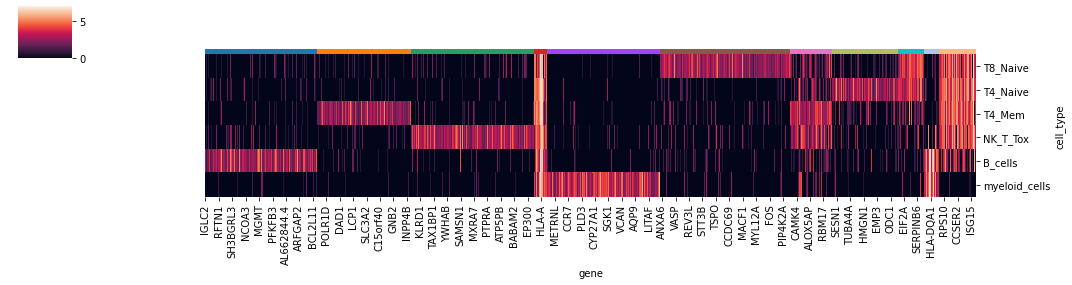

In [754]:
cg = sns.clustermap(log_cpg.iloc[:,np.argsort(kmeans.labels_)], figsize=(15,4), 
                    row_cluster=False,
                    col_cluster=False,
                    col_colors=list(map(lambda x: kmeans_color_dict[x], np.sort(kmeans.labels_))),
                   );
# plt.tight_layout()

## Mean CPG per Gene Group

In [755]:
groups = np.arange(n_clusts)
groups_genes = dict(zip(groups, [log_cpg.columns[kmeans.labels_ == i].values for i in range(n_clusts)]))

/home/ssm-user/miniconda3/envs/clue/lib/python3.6/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


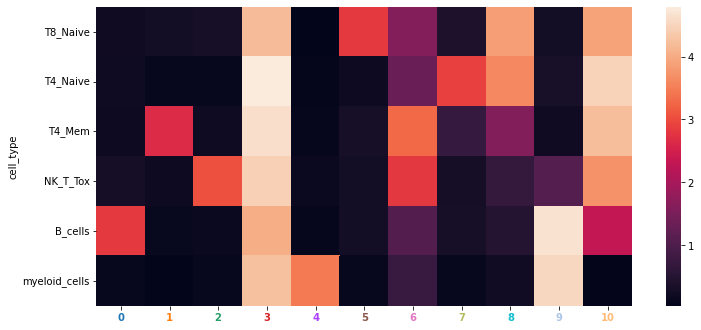

In [756]:
plt.figure(figsize=(12, 5.5))
mean_log_cpg = pd.concat([log_cpg[groups_genes[group]].mean(1) for group in groups], axis=1)
ax = sns.heatmap(mean_log_cpg)
for text in ax.get_xticklabels():
    text.set_color(mpl.colors.hex2color(kmeans_color_dict[int(text.get_text())]));
    text.set_fontweight(1000)

Cool, looks like a mixture of cell-type specific vs shared effects.

I want to show the ones that are specific on the left and move more and more to shared gene groups on the right.

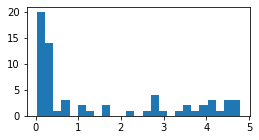

In [757]:
plt.figure(figsize=(4,2))
plt.hist(mean_log_cpg.values.flatten(), bins=25);

In [758]:
kmeans_sorted = (mean_log_cpg > meanlogcpg_thresh).sum(0).sort_values()
kmeans_order = kmeans_sorted.index
kmeans_sorted

# kmeans_sorted = (mean_log_cpg > 1.1).sum(0).sort_values()
# kmeans_order = kmeans_sorted.index
# kmeans_sorted

0     1
1     1
2     1
4     1
5     1
7     1
6     2
8     2
9     2
10    5
3     6
dtype: int64

A `mean_log_cpg` of `2` seems to be a good threshold for finding groups of genes that are specific to every cell type at least once.

/home/ssm-user/miniconda3/envs/clue/lib/python3.6/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


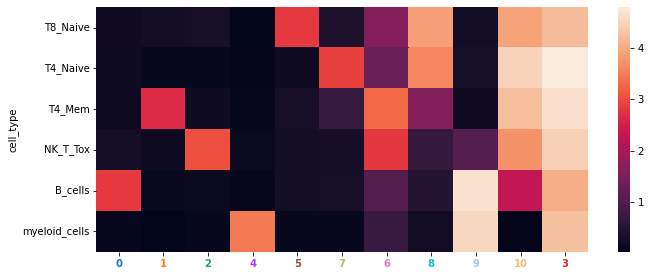

In [759]:
plt.figure(figsize=(11, 4.5))
ax = sns.heatmap(mean_log_cpg[kmeans_order])
for text in ax.get_xticklabels():
    text.set_color(mpl.colors.hex2color(kmeans_color_dict[int(text.get_text())]));
    text.set_fontweight(1000)

Now let's rearrange the columns to make it looks prettier.

/home/ssm-user/miniconda3/envs/clue/lib/python3.6/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


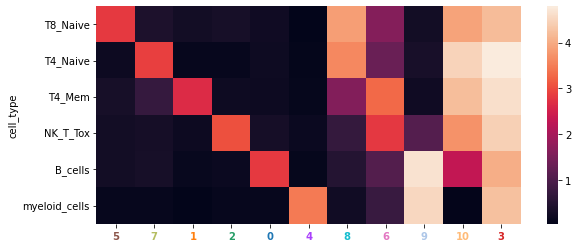

In [760]:
mean_log_cpg = mean_log_cpg[revised_kmeans_order]
plt.figure(figsize=(9.5, 4))
ax = sns.heatmap(mean_log_cpg)
for text in ax.get_xticklabels():
    text.set_color(mpl.colors.hex2color(kmeans_color_dict[int(text.get_text())]));
    text.set_fontweight(1000)

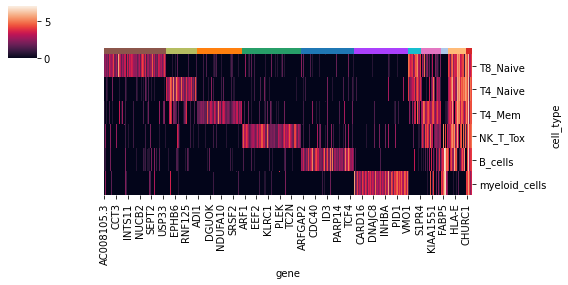

In [761]:
cg = sns.clustermap(log_cpg[[i for j in [groups_genes[group] for group in revised_kmeans_order] for i in j]], figsize=(8,4), 
                    row_cluster=False,
                    col_cluster=False,
                    col_colors=list(map(lambda x: kmeans_color_dict[x], 
                                        np.repeat(revised_kmeans_order, pd.Series(kmeans.labels_).value_counts().loc[revised_kmeans_order].values))),
                   );

## Generate Peaks

In [762]:
score_name = 'score'

In [763]:
narrow_peaks = dict()
for ct in tqdm(cts):
    narrow_peaks[ct] = pd.read_csv(prefix_pks + 'macs2/ctrl_by_ct_noctrlset/%s/%s_peaks.narrowPeak' % (ct, ct), sep='\t', header=None)
    narrow_peaks[ct].columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'rawScore', 'spectrumId', 'peptideRank', 'peptideRepeatCount']
    narrow_peaks[ct]['peak_num'] = narrow_peaks[ct]['name'].str.split('_').str[-1].replace(r'[a-z]', '', regex=True).astype(int)
    narrow_peaks[ct].set_index('peak_num', inplace=True)
    narrow_peaks[ct].sort_values(by=['peak_num', score_name], ascending=False, inplace=True)

  0%|          | 0/6 [00:00<?, ?it/s]

Peaks are returned from `macs2` with scores, visualized here.

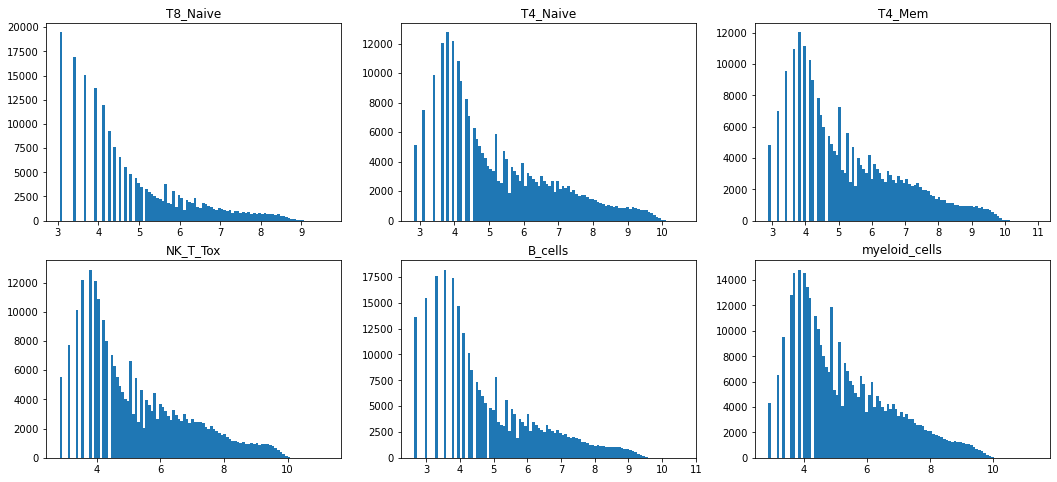

In [764]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8))
for ct, ax in zip(cts, np.ravel(ax)):
    ax.hist(np.log1p(narrow_peaks[ct][score_name].values), bins=100); #np.logspace(np.log10(nzmin), np.log10(1), 50))
    ax.set_title(ct)

Threshold peaks, keeping only those with scores above 5.

In [765]:
# narrow peaks, hiscore, deduped
nphsd = dict()
for ct in cts:
    nphsd[ct] = narrow_peaks[ct][~narrow_peaks[ct].index.duplicated()].sort_values(by='peak_num')
    nphsd[ct] = nphsd[ct][np.log1p(nphsd[ct][score_name]) > peak_score_thresh]
    print((ct, len(nphsd[ct])))

('T8_Naive', 39949)
('T4_Naive', 53808)
('T4_Mem', 55077)
('NK_T_Tox', 56282)
('B_cells', 56597)
('myeloid_cells', 91116)


Now I will take the top $n$ peaks from each cell type.

In [766]:
# narrow peaks, hiscore, deduped, top_peaks
nphsdt = dict()
for ct in cts:
    
    nphsdt[ct] = nphsd[ct].loc[nphsd[ct].sort_values(by=score_name, ascending=False).index[:top_num_peaks]]
#     nphsdt[ct] = nphsd[ct].loc[np.log1p(nphsd[ct][score_name]) > threshs[ct]].copy()
    
print([len(nphsdt[ct]) for ct in cts])

[25000, 25000, 25000, 25000, 25000, 25000]


Visualize the scores again for these top peaks.

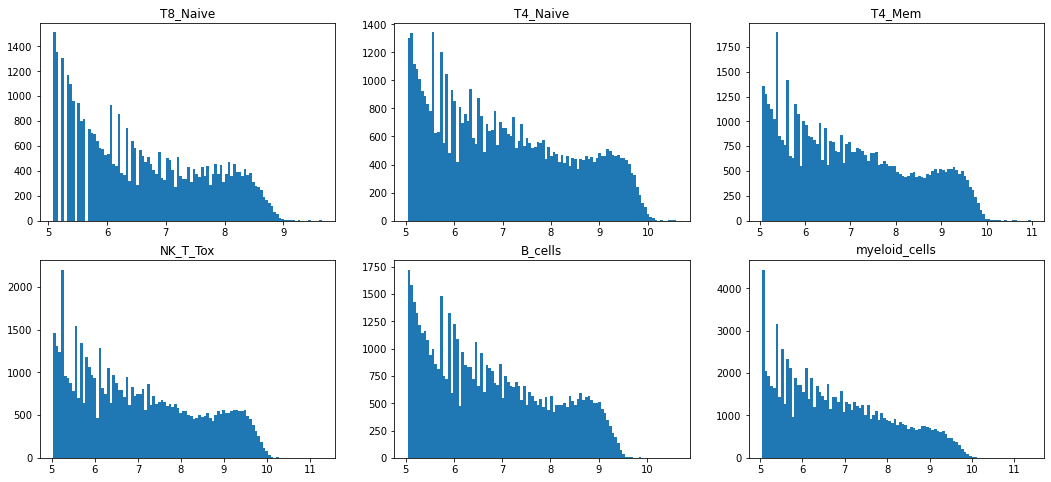

In [767]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8))
for ct, ax in zip(cts, np.ravel(ax)):
    ax.hist(np.log1p(nphsd[ct][score_name].values), bins=100); #np.logspace(np.log10(nzmin), np.log10(1), 50))
    ax.set_title(ct)

Make `.bed` files for the peaks.

In [768]:
for ct in cts:
    nphsdt[ct]['rank'] = range(len(nphsdt[ct]))

In [769]:
nphsdt_beds = dict() # narrow peaks, hiscore, deduped
for ct in cts:
    nphsdt_beds[ct] = pybedtools.BedTool([pybedtools.Interval(*i) for i in nphsdt[ct][['chrom', 'chromStart', 'chromEnd', 'name']].values])

In [770]:
nphsdt['all'] = pd.concat([nphsdt[ct] for ct in cts]).sort_values(by=['chrom', 'chromStart']).reset_index(drop=True)

In [771]:
nphsdt_beds['all'] = pybedtools.BedTool([pybedtools.Interval(*i) for i in nphsdt['all'][['chrom', 'chromStart', 'chromEnd', 'name']].values])

# Intersect Cell type-specific Peaks and eQTLs

In [772]:
sort_by = 'abs(beta)'

In [773]:
vcounts = list()
for ct in tqdm(cts):
    gene_group = gene_group_dict[ct]
    df = mateqtl_df_filt[((mateqtl_df_filt['gene'].isin(groups_genes[gene_group])) & 
                             (mateqtl_df_filt['cell_type'] == ct))].sort_values(by=sort_by, ascending=False)
    genes_loci = dict()
    genes_spread = dict()
    
    genes_to_use = df['gene'].unique()
#     genes_to_use = s_ratios[ct][s_ratios[ct] > 0].index

    for gene in genes_to_use:
        genes_loci[gene] = [int(i[1]) for i in df[(df['gene'] == gene) & (df['cell_type'] == ct)].index.str.split(':')]
        region = df[df['gene'] == gene].index[0].split(':')[0] + ':' + str(min(genes_loci[gene])) + '-' + str(max(genes_loci[gene]))
        genes_spread[gene] = (region, max(genes_loci[gene]) - min(genes_loci[gene]))
    genes_regions_as_list = [(re.split(':|-', genes_spread[i][0]), i) for i in genes_spread]

    ct_eqtl_genes_bed = pybedtools.BedTool([pybedtools.Interval(*['chr' + k[0], int(k[1]), int(k[2]), i]) for k, i in genes_regions_as_list])
    names = ['peak_chrom', 'peak_start', 'peak_end', 'peak_name', 'eqtl_chrom', 'eqtl_start', 'eqtl_end', 'gene_name']
    
    isec_df = nphsdt_beds['all'].intersect(ct_eqtl_genes_bed, wo=True).to_dataframe(disable_auto_names=True, header=None)
    isec_df = isec_df.loc[:, ~isec_df.apply(lambda x: (x == '.').all())]
    isec_df.drop(columns=[12], inplace=True)
    isec_df.columns = names
    isec_df.set_index('peak_name', inplace=True)
    
    nphsdt_ct_isec = nphsdt['all'].set_index('name').join(isec_df['gene_name']).dropna()
    nphsdt_ct_isec['cell_type'] = nphsdt_ct_isec.index.str[::-1].str.split('_', n=2).str[-1].str[::-1]
    nphsdt_ct_isec['cell_type'].value_counts()
    vcounts.append(nphsdt_ct_isec['cell_type'].value_counts())

  0%|          | 0/6 [00:00<?, ?it/s]

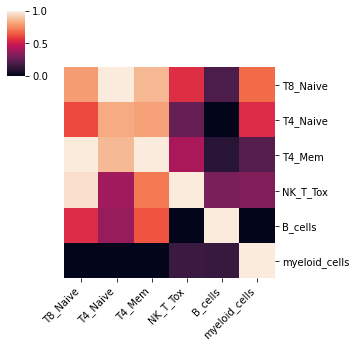

In [780]:
cg = sns.clustermap(pd.concat(vcounts, axis=1, keys=cts).loc[cts], 
                    standard_scale=1, 
                    row_cluster=False, col_cluster=False, figsize=(5,5));
cg.ax_heatmap.set_xticklabels(cts, rotation=45, ha='right');
cg.ax_cbar.set_visible(True)

In [775]:
ct_groups = [[ct] for ct in cts] + [
    ['B_cells', 'myeloid_cells'],
    ['T4_Naive', 'T8_Naive', 'T4_Mem', 'NK_T_Tox'],
    ['T4_Naive', 'T8_Naive', 'T4_Mem', 'NK_T_Tox', 'B_cells'],
    ['T4_Naive', 'T8_Naive', 'T4_Mem', 'NK_T_Tox', 'B_cells', 'myeloid_cells']
]

In [776]:
vcounts = list()
for ct_group, gene_group in tqdm(zip(ct_groups, revised_kmeans_order), total=len(ct_groups)):
    df = mateqtl_df_filt[((mateqtl_df_filt['gene'].isin(groups_genes[gene_group])) & 
                             (mateqtl_df_filt['cell_type'].isin(ct_group)))].sort_values(by=sort_by, ascending=False)
    genes_loci = dict()
    genes_spread = dict()
    for gene in df['gene'].unique():
        genes_loci[gene] = [int(i[1]) for i in df[(df['gene'] == gene) & (df['cell_type'].isin(ct_group))].index.str.split(':')]
        region = df[df['gene'] == gene].index[0].split(':')[0] + ':' + str(min(genes_loci[gene])) + '-' + str(max(genes_loci[gene]))
        genes_spread[gene] = (region, max(genes_loci[gene]) - min(genes_loci[gene]))
    genes_regions_as_list = [(re.split(':|-', genes_spread[i][0]), i) for i in genes_spread]

    ct_eqtl_genes_bed = pybedtools.BedTool([pybedtools.Interval(*['chr' + k[0], int(k[1]), int(k[2]), i]) for k, i in genes_regions_as_list])
    names = ['peak_chrom', 'peak_start', 'peak_end', 'peak_name', 'eqtl_chrom', 'eqtl_start', 'eqtl_end', 'gene_name']
    
    isec_df = nphsdt_beds['all'].intersect(ct_eqtl_genes_bed, wo=True).to_dataframe(disable_auto_names=True, header=None)
    isec_df = isec_df.loc[:, ~isec_df.apply(lambda x: (x == '.').all())]
    isec_df.drop(columns=[12], inplace=True)
    isec_df.columns = names
    isec_df.set_index('peak_name', inplace=True)
    
    nphsdt_ct_isec = nphsdt['all'].set_index('name').join(isec_df['gene_name']).dropna()
    nphsdt_ct_isec['cell_type'] = nphsdt_ct_isec.index.str[::-1].str.split('_', n=2).str[-1].str[::-1]
    nphsdt_ct_isec['cell_type'].value_counts()
    vcounts.append(nphsdt_ct_isec['cell_type'].value_counts())

  0%|          | 0/10 [00:00<?, ?it/s]

In [777]:
vcounts_df = pd.concat(vcounts, axis=1, keys=['__'.join(ct_group) for ct_group in ct_groups]).loc[cts]

In [778]:
vcounts_std = vcounts_df.copy()
vcounts_std = vcounts_std.subtract(vcounts_std.min(axis=0), axis=1)
vcounts_std = vcounts_std.divide(vcounts_std.max(axis=0), axis=1)

/home/ssm-user/miniconda3/envs/clue/lib/python3.6/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


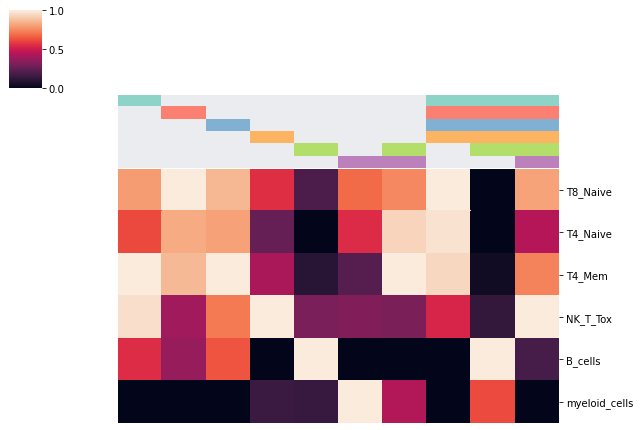

In [779]:
sns.clustermap(vcounts_std, row_cluster=False, col_cluster=False, figsize=(9,6), 
               xticklabels=False,
               col_colors=[[ct_colors[ct] if (ct in i) else '#EBECF0' for i in ct_groups] for ct in cts]
              );

# Extra

## Find Specific ATAC Peaks

Try different peaks sets, maybe it's something about the peak set I'm using?

### Merged, Separate on Coverage

Calling cell-type specific peaks is a difficult problem. Instead, I called on the merged dataset and then here I will separate out based on coverage.

In [95]:
atac = pd.concat([pd.read_csv(prefix_pks + 'downsamp/all_cts/%s_peaks_bam_count.bed' % ct, sep='\t', header=None) for ct in cts_enrich], axis=0, keys=cts_enrich)
genome = 'hg38'

In [96]:
atac = atac.reset_index()
atac.columns = ['group', 'peak_id', 'chrom', 'start', 'end', 'peak_name', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'summit', 'coverage']

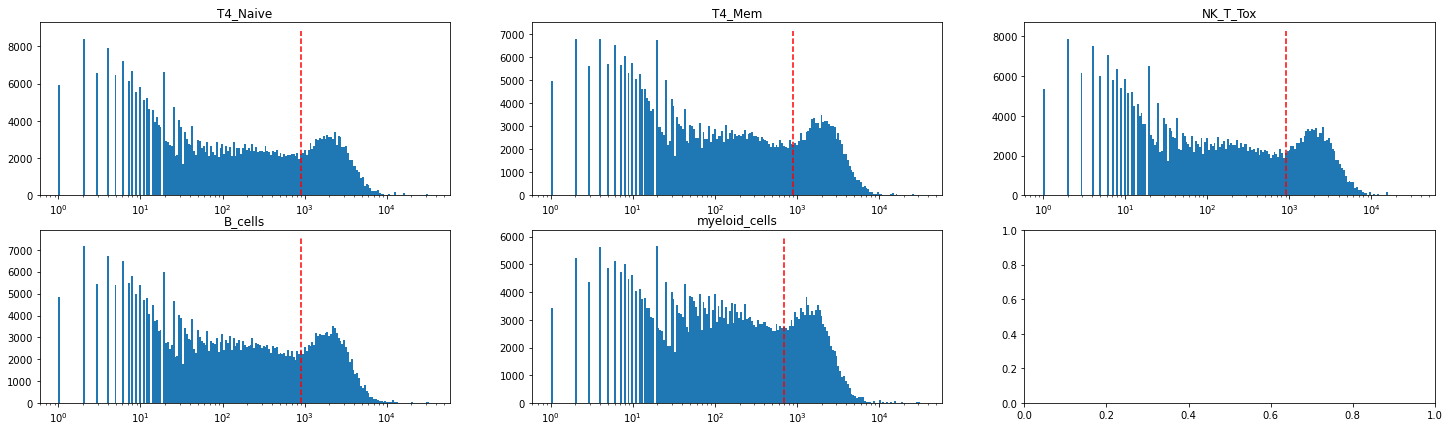

In [97]:
threshs = [9e2, 9e2, 9e2, 9e2, 7e2]
fig, ax = plt.subplots(2, 3, figsize=(25, 7))
for ct, ax, thresh in zip(cts_enrich, np.ravel(ax), threshs):
    ax.hist(atac[atac['group'] == ct]['coverage'], bins=np.logspace(np.log10(1), np.log10(35000), 200))
    ax.vlines(thresh, *ax.get_ylim(), color='red', linestyle='--')
    ax.set_xscale('log')
    ax.set_title(ct)

In [122]:
# filtered_vals = filter_vals(atac, 'group', 'peak_id', filter_name='coverage', thresh=dict(zip(cts_enrich,threshs)))
filtered_vals = filter_vals(atac, 'group', 'peak_id', filter_name='coverage', thresh=1e2)

In [123]:
filtered_vals['group'].value_counts()

myeloid_cells    203451
B_cells          194136
T4_Mem           191517
NK_T_Tox         187850
T4_Naive         185928
Name: group, dtype: int64

In [189]:
specific_vals = find_specific_vals(cts_enrich, [filtered_vals[filtered_vals['group'] == g]['peak_id'].values for g in cts_enrich])

In [190]:
for ct in cts_enrich:
    print((ct, specific_vals[ct].shape))

('T4_Naive', (4669,))
('T4_Mem', (2006,))
('NK_T_Tox', (6750,))
('B_cells', (13296,))
('myeloid_cells', (29522,))


In [191]:
atac_specific = get_specific_df(atac, 'group', 'peak_id', specific_vals)

In [192]:
atac_specific['group'].value_counts()

myeloid_cells    29522
B_cells          13296
NK_T_Tox          6750
T4_Naive          4669
T4_Mem            2006
Name: group, dtype: int64

In [193]:
atac_specific = filter_vals(atac_specific, 'group', 'peak_id', filter_name='coverage', top_num=2000)

In [194]:
atac_specific['group'].value_counts()

T4_Mem           2000
T4_Naive         2000
NK_T_Tox         2000
myeloid_cells    2000
B_cells          2000
Name: group, dtype: int64

### Forgot How I Made These

In [ ]:
# atac = pd.concat([pd.read_csv(prefix_pks + 'downsamp/%s/subsamp_no_P/C_%s_peaks_bam_count.bed' % (ct, ct), sep='\t', header=None) for ct in cts_enrich], axis=0)
# atac['group'] = atac[3].str.split('_merged_peak_').str[0]
# atac.columns = ['chrom', 'start', 'end', 'peak_name', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'summit', 'coverage', 'group']
genome = 'hg38'

In [ ]:
# atac = pd.concat([pd.read_csv(prefix_pks + 'macs2/ctrl_by_ct/%s/%s_peaks.narrowPeak' % (ct, ct), sep='\t', header=None) for ct in cts_enrich], axis=0)
# atac['group'] = atac[3].str.split('_peak_').str[0]
# atac.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'peak', 'group']
genome = 'hg38'

In [328]:
nk_metasoft = pd.read_csv(prefix_eqtl + 'nk_metasoft_out.txt', sep='\t')

/home/ssm-user/miniconda3/envs/clue/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (5,6,8,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [345]:
locs = nk_metasoft.index.get_level_values(0).str.split('_').str[0].str.split(':')

In [346]:
locs1 = np.unique(np.array([':'.join(i) for i in locs]))

In [359]:
locs1 = pd.Series(locs1)

In [371]:
locs1

0          10:100043981
1          10:100044928
2          10:100045000
3          10:100045147
4          10:100045166
               ...     
1796198      9:99802796
1796199      9:99804997
1796200      9:99805079
1796201      9:99806169
1796202      9:99806787
Length: 1796203, dtype: object

In [339]:
locs2 = np.unique(mateqtl_df_C.index.values)

In [360]:
locs2 = pd.Series(locs2)

In [369]:
print((locs1[locs1.str.split(':').str[0] == '22'].shape, locs2[locs2.str.split(':').str[0] == '22'].shape))

((38796,), (19642,))


In [368]:
np.setdiff1d(locs1[locs1.str.split(':').str[0] == '22'], locs2[locs2.str.split(':').str[0] == '22'], assume_unique=True).shape

(20207,)

In [370]:
locs1

0          10:100043981
1          10:100044928
2          10:100045000
3          10:100045147
4          10:100045166
               ...     
1796198      9:99802796
1796199      9:99804997
1796200      9:99805079
1796201      9:99806169
1796202      9:99806787
Length: 1796203, dtype: object

In [337]:
np.intersect1d(, np.unique(locs), assume_unique=True)

KeyboardInterrupt: 

array(['10:100043981', '10:100044928', '10:100045000', ..., '9:99805079',
       '9:99806169', '9:99806787'], dtype='<U12')

In [83]:
nk_t_tox = mateqtl_df[mateqtl_df['cell_type'] == 'NK_T_Tox']['hg19_snps'].values

In [84]:
nk_t_tox = np.array(sorted(nk_t_tox))

In [89]:
print((locs.shape, nk_t_tox.shape))

((3379632,), (1600798,))


In [92]:
np.intersect1d(nk_t_tox[:100000], locs[:100000]).shape

(24861,)